In [1]:
from IPython.display import display, HTML
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
import tensorflow as tf
import numpy as np


from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn import metrics


from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

Using TensorFlow backend.


### Lectura de archivos en Disco

In [2]:
files_names = []
for filename in glob.glob("datos/precios/*"):
    files_names.append(filename)

In [5]:
files_names.sort()
files_names[0:5]

['datos/precios\\Precio_Bolsa_Nacional_($kwh)_1995.xlsx',
 'datos/precios\\Precio_Bolsa_Nacional_($kwh)_1996.xlsx',
 'datos/precios\\Precio_Bolsa_Nacional_($kwh)_1997.xlsx',
 'datos/precios\\Precio_Bolsa_Nacional_($kwh)_1998.xlsx',
 'datos/precios\\Precio_Bolsa_Nacional_($kwh)_1999.xlsx']

### Lectura de los Datos

In [6]:
precio_final = pd.read_excel(files_names[0],skiprows = 3)

In [7]:
for i in range(1,len(files_names)):    
    cont = 0
    
    while(True): 
        
        precio_i = pd.read_excel(files_names[i],skiprows = cont).iloc[:,0:25]  
        
        if precio_i.columns[0] == 'Fecha':
            break
        elif cont >= 15:
            break
        else:
            cont+=1

    precio_final = pd.concat([precio_final,precio_i],ignore_index=True,axis=0) 

In [8]:
for i in range(precio_final.shape[0]):
    if type(precio_final.iloc[i,0]) != str:
        print(precio_final.iloc[i,0])
        print(type(precio_final.iloc[i,0]))
        break

1996-02-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [9]:
precio_final["Fecha"] = pd.to_datetime(precio_final["Fecha"])

In [10]:
precio_final = precio_final.sort_values(by=['Fecha'])

In [11]:
serie = pd.concat([precio_final["Fecha"],precio_final.mean(axis=1)],axis=1)

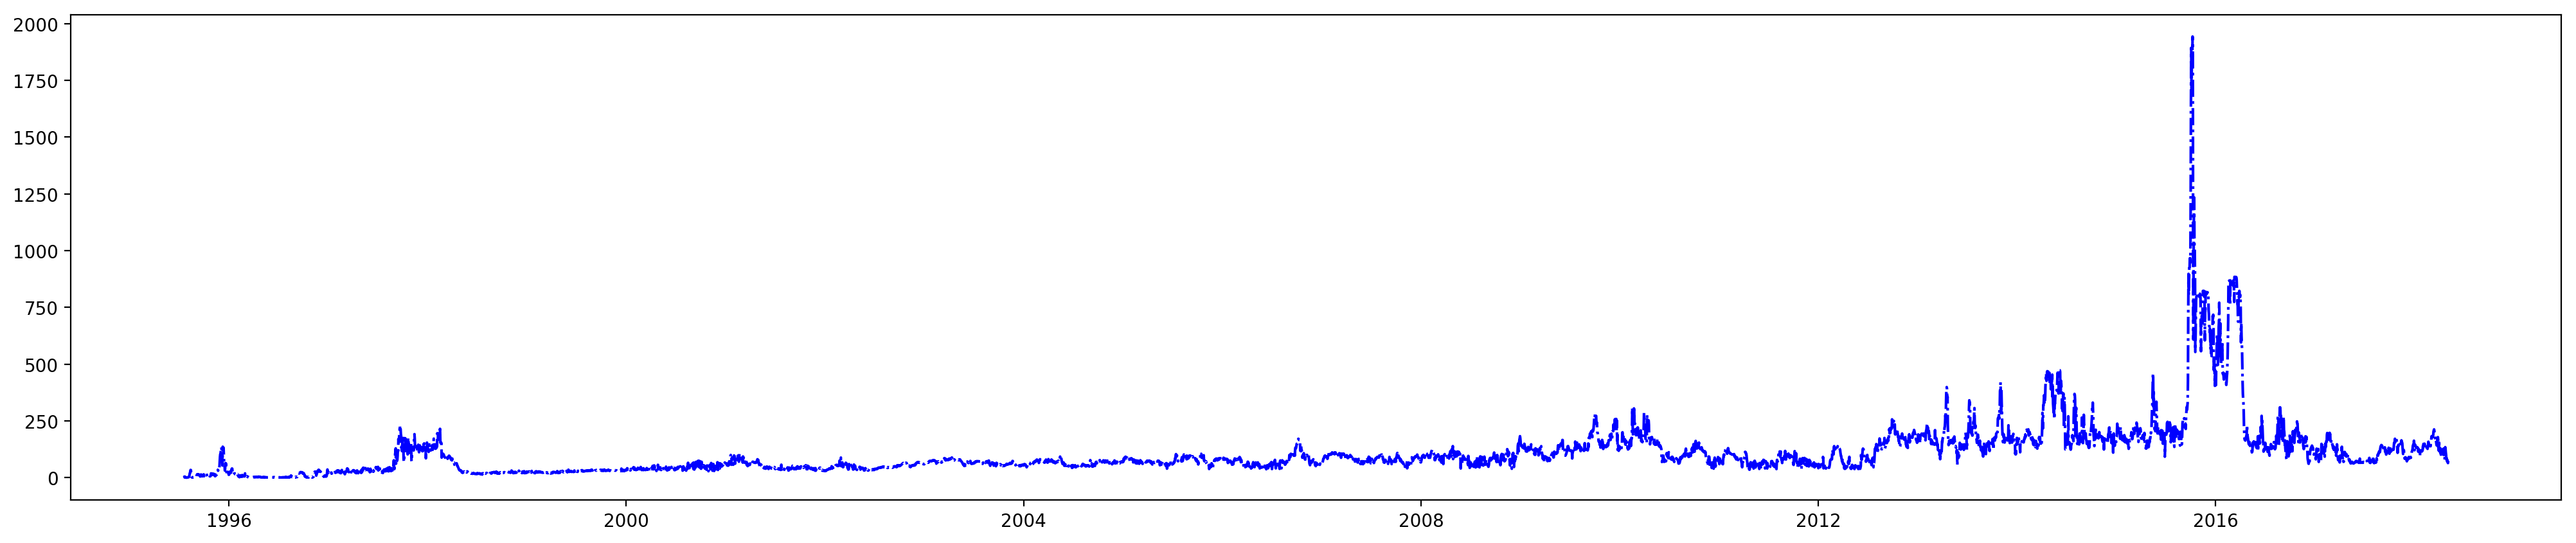

In [16]:
figure(num=None, figsize=(25,5), dpi=200, facecolor='w', edgecolor='k')
plt.plot(serie["Fecha"], serie.iloc[:,1],'b-.')
plt.show()

In [17]:
serie = serie.dropna() 

In [18]:
serie.isnull().sum()

Fecha    0
0        0
dtype: int64

In [19]:
serie = serie.reset_index(drop=True)

In [20]:
serie.columns = ["fecha","price"]

### feature scaling

In [21]:
sc = MinMaxScaler(feature_range = (0, 1))

d = sc.fit_transform(serie["price"].values.reshape(-1,1)).reshape(-1,)

### Construcción de modelo de pronostico adaptativo sin transformaciones


In [22]:
dias_a_predecir = 24*7

In [23]:
tf.enable_eager_execution()

In [24]:
class Model(object):
    def __init__(self, L):        
        # Creacion del vector de pesos
        self.w = tf.Variable([0.0] * (L))

    def __call__(self, x):
        # Añado bias a mi entrada y lo múltiplico por mis pesos para obtener el pronóstico
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        # multiplico por mis pesos
        y_pred = self(x)
        # saco mi error
        e = y_desired - y_pred
        # BIAS
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        # gradient...
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))
        
        

### Calibración número de retardos adecueado

In [25]:
# Nro de retardos a probar
retardos = [2,3,4,5,6,7,8,10]

In [26]:
def tuning_retardos(retardos,d):
    
    resultado_retardos = []

    for i in range(len(retardos)):

        L = retardos[i]

        model = Model(L)

        y_pred = np.empty(len(d))
        y_pred[:] = np.nan

        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=0.05, x=x, y_desired=d[t])

        resultado_retardos.append([d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]])
        
    return resultado_retardos

resultado_retardos = tuning_retardos(retardos,d)

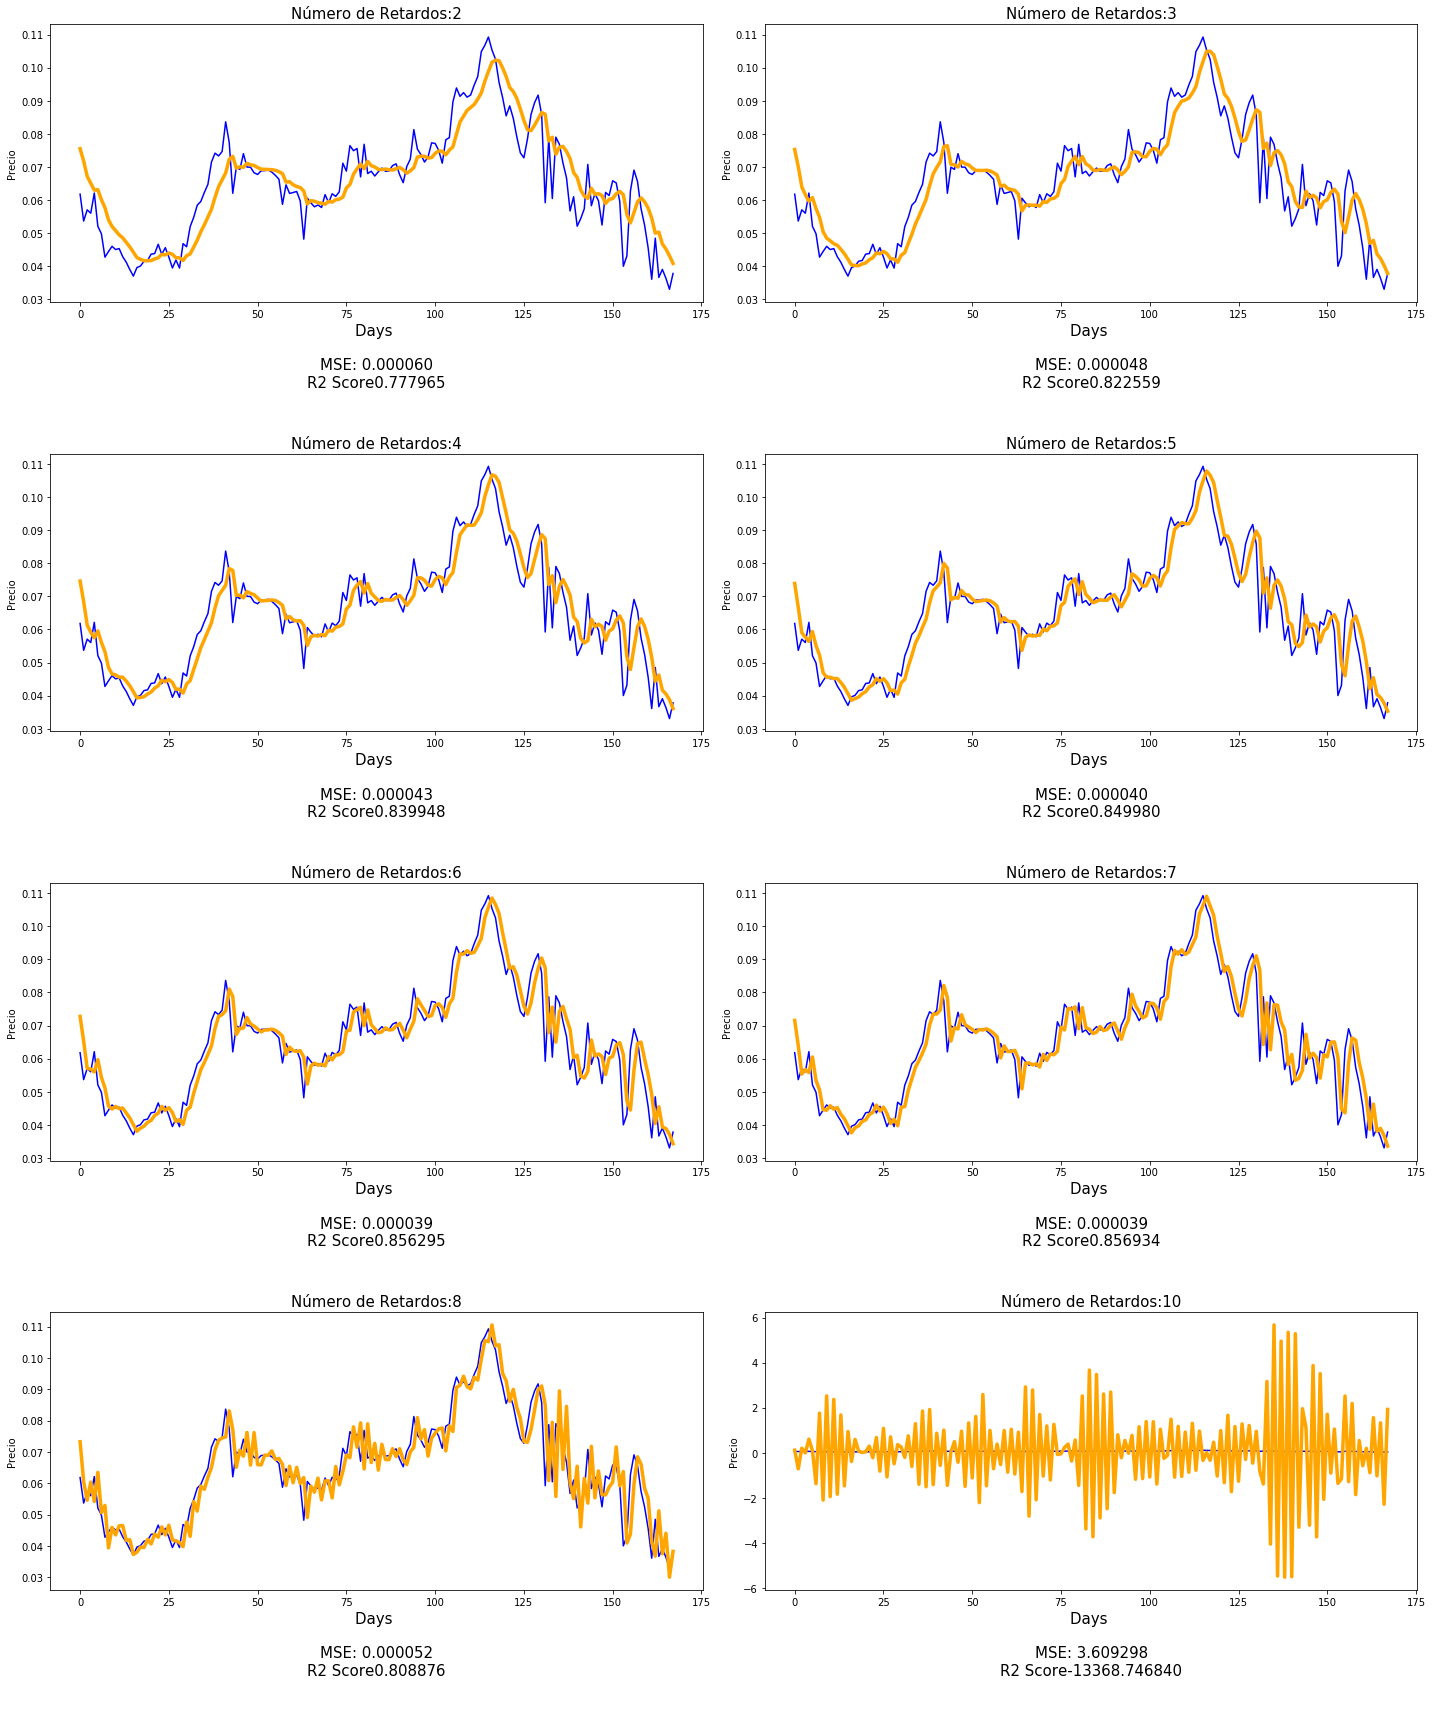

In [31]:
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(20,24))

count = 0
for fila in axes:

    for ax in fila:    

        titulo = str("Número de retardos:"+str(retardos[count])) 

        ax.plot(resultado_retardos[count][0],color = 'blue',label = 'Data')
        ax.plot(resultado_retardos[count][1],color = 'orange',label = 'Prediction',linewidth=3.5)

        ax.set_xlabel('Days \n \n'+                     
                      str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(resultado_retardos[count][0],resultado_retardos[count][1])))+'\n'+
                      str('R2 Score' + '{:f}'.format(r2_score(resultado_retardos[count][0],resultado_retardos[count][1]))+'\n \n'),fontsize=15) 

        ax.set_ylabel('Precio')
        ax.set_title(str('Número de Retardos:'+str(retardos[count])),fontsize=15)

        fig    
        plt.tight_layout()

        count+=1

### Calibración tasa de aprendizaje

In [38]:
lr = [0.02, 0.01,0.001,0.0001]

In [39]:
resultado_lr = []

for i in range(len(lr)):
    
    L = 7

    model = Model(L)

    y_pred = np.empty(len(d))
    y_pred[:] = np.nan

    for t in range(L, len(d)):
        x = d[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=lr[i], x=x, y_desired=d[t])

    resultado_lr.append([d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]])

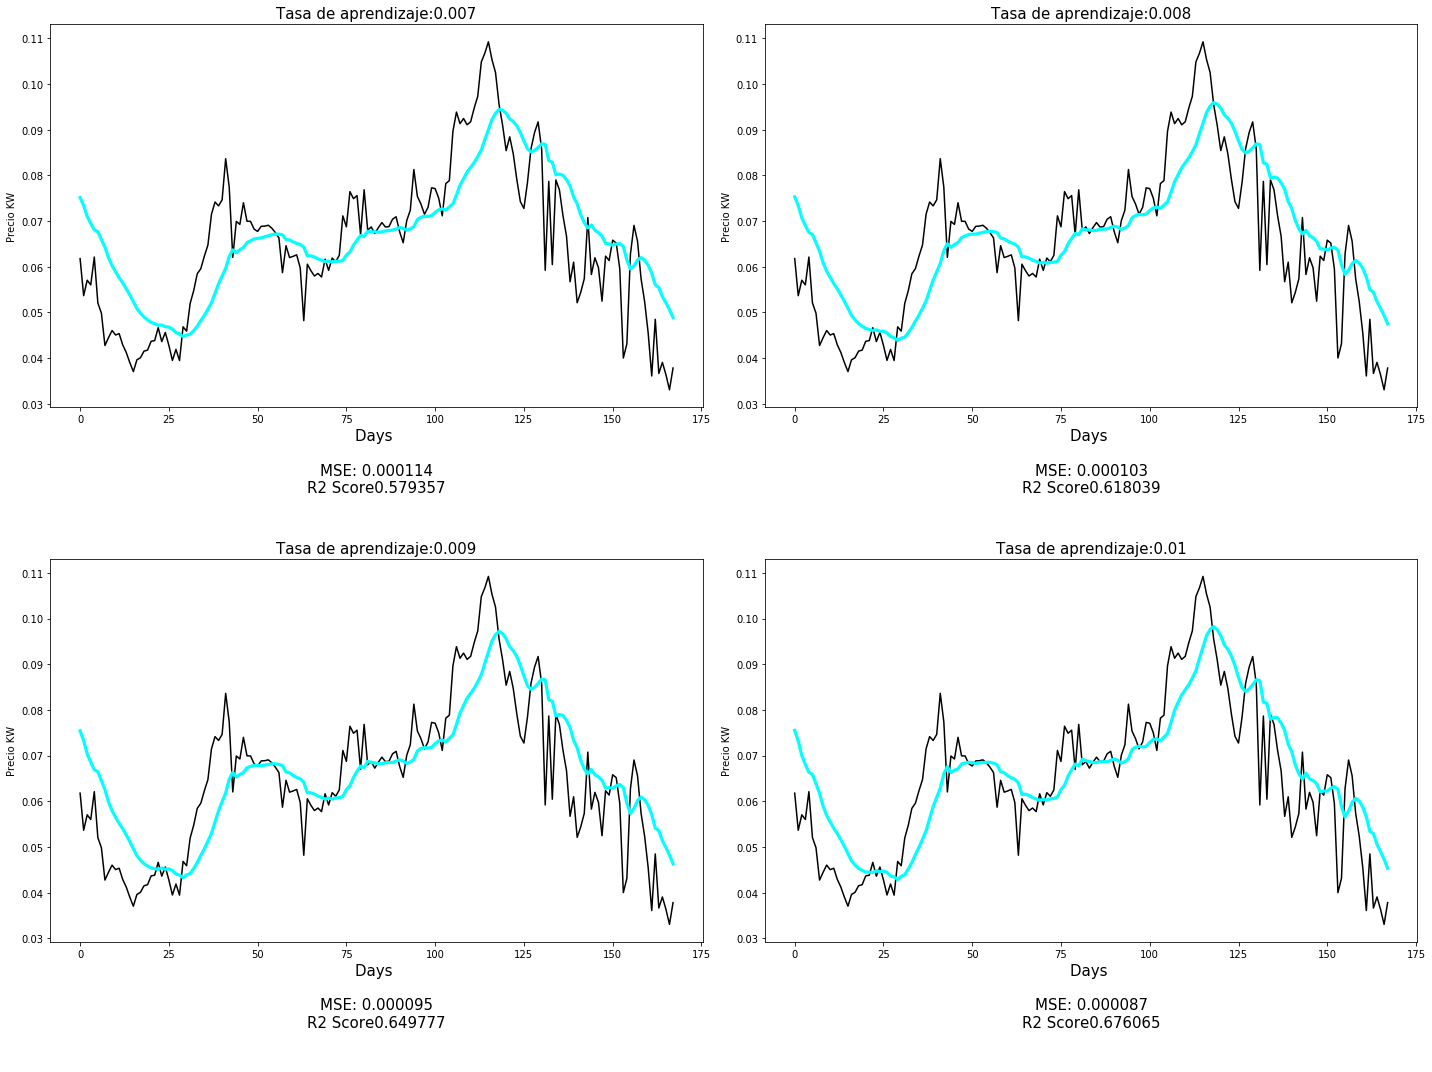

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,15))

count = 0
for fila in axes:
    
    for ax in fila:    

        titulo = str("Número de retardos:"+str(retardos[count])) 

        ax.plot(resultado_lr[count][0],color = 'black',label = 'Data')
        ax.plot(resultado_lr[count][1],color = 'cyan',label = 'Prediction',linewidth=3.2)

        ax.set_xlabel('Days \n \n'+                     
                      str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(resultado_lr[count][0],resultado_lr[count][1])))+'\n'+
                      str('R2 Score' + '{:f}'.format(r2_score(resultado_lr[count][0],resultado_lr[count][1]))+'\n \n'),fontsize=15) 
                     
        ax.set_ylabel('Precio KW')
        ax.set_title(str('Tasa de aprendizaje:'+str(lr[count])),fontsize=15)

        fig    
        plt.tight_layout()

        count+=1


#### Con base en las observaciones realizadas se toman valores para el learning rate mas cercanas a los valores de 0.02 y 0.01 para encontrar el valor adecuado.

In [41]:
lr = [0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05,0.06,0.07]

In [42]:
def tuning_lr(lr,d):
    
    resultado_lr = []

    for i in range(len(lr)):    
        L = 6

        model = Model(L)

        y_pred = np.empty(len(d))
        y_pred[:] = np.nan

        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=lr[i], x=x, y_desired=d[t])

        resultado_lr.append([d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]])
        
    return resultado_lr

resultado_lr = tuning_lr(lr,d)

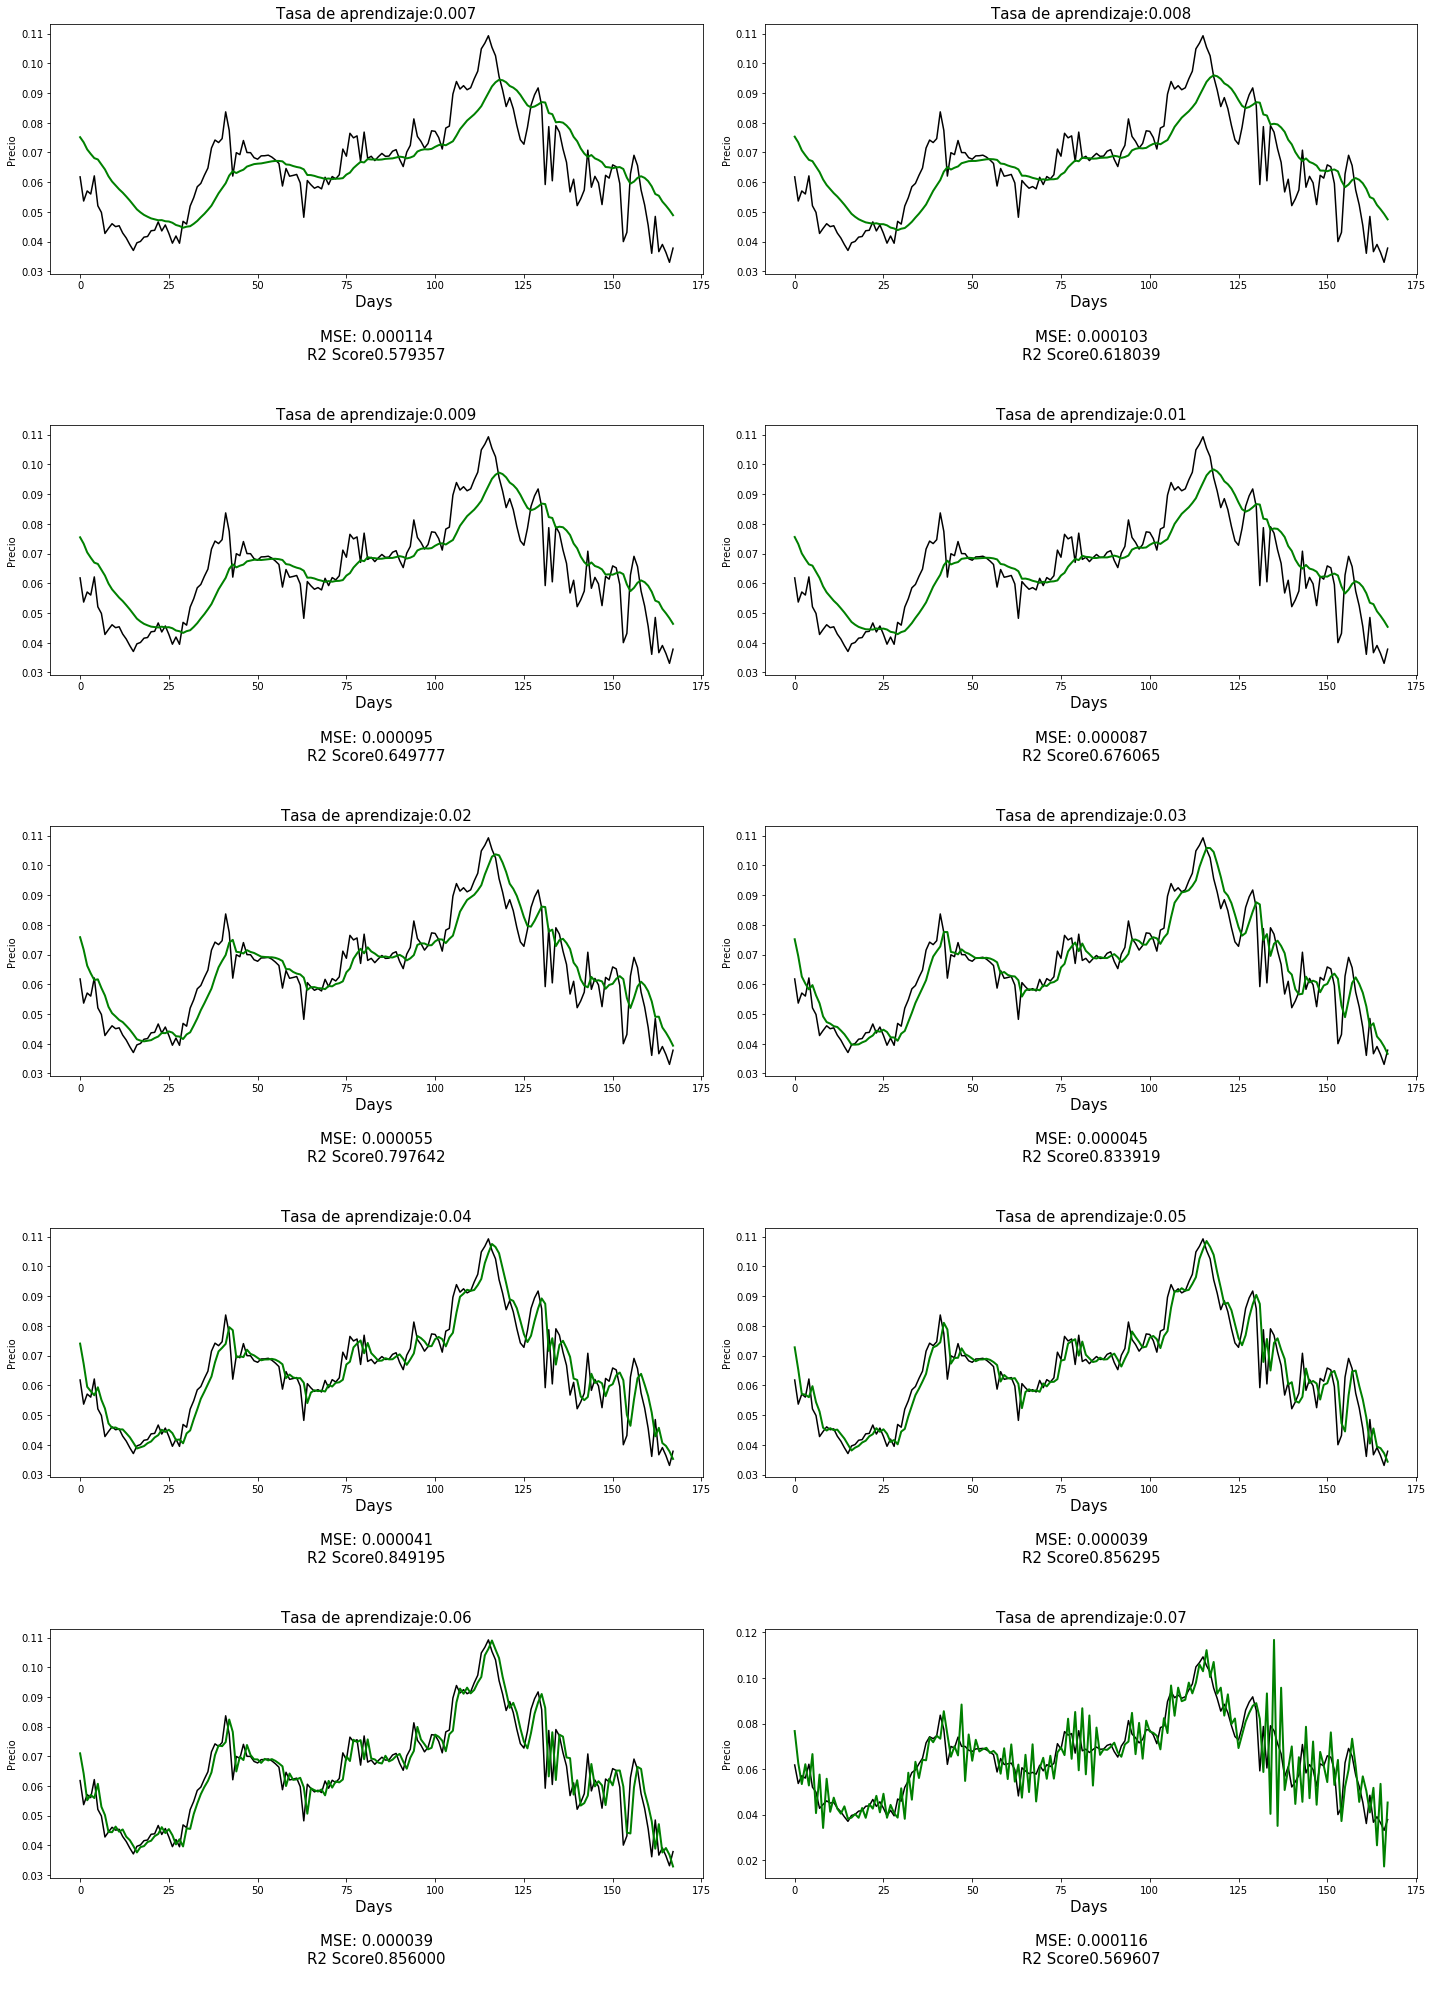

In [45]:
fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(20,28))

count = 0
for fila in axes:
    
    for ax in fila:

        titulo = str("Tasa de aprendizaje:"+str(lr[count])) 

        ax.plot(resultado_lr[count][0],color = 'black',label = 'Data ')
        ax.plot(resultado_lr[count][1],color = 'green',label = 'Prediction',linewidth=2.0)

        ax.set_xlabel('Days \n \n'+                     
                      str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(resultado_lr[count][0],resultado_lr[count][1])))+'\n'+
                      str('R2 Score' + '{:f}'.format(r2_score(resultado_lr[count][0],resultado_lr[count][1]))+'\n \n'),fontsize=15) 
                     
        ax.set_ylabel('Precio')
        ax.set_title(str('Tasa de aprendizaje:'+str(lr[count])),fontsize=15)

        fig    
        plt.tight_layout()

        count+=1


#### Podemos concluir que la tasa adecuada para este problema es de 0.05

## Modelo sin transformación con los parámetros óptimos

In [46]:
def graficar_modelo(real,pred,nombre):
    """
    Función para gráficar el resultado y métricas de los modelos
    """
    figure(figsize=(12,6))
    plt.plot(real, color = 'black', label = 'Data')
    plt.plot(pred, color = 'red', label = 'Prediction')
    plt.title(nombre)
    plt.xlabel('Horas/Día \n \n'+
              'R2: '+str(r2_score(real,pred))+'\n \n'
              'MSE: '+str(metrics.mean_squared_error(real, pred))
              )
    plt.ylabel('Precio')
    plt.legend()
    return plt.show()

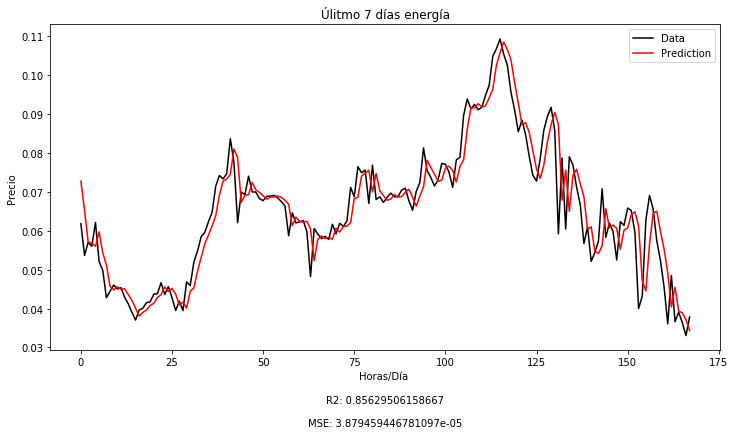

In [47]:
def adaline(L,lr,d):
    L = L

    model = Model(L)

    y_pred = np.empty(len(d))
    y_pred[:] = np.nan

    for t in range(L, len(d)):
        x = d[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=lr, x=x, y_desired=d[t])
    
    return [d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]]
    
modelo_sin_transf = adaline(6,0.05,d)

graficar_modelo(modelo_sin_transf[0],modelo_sin_transf[1],"Úlitmo 7 días energía")

### Selección de transformación adecuada para el modelo
Evaluaremos las siguientes trasformaciones para realizar la selección de la mejor.
 
 * Raiz Cuadrada
 * Raíz Cúbica
 * Logaritmo Natural

In [48]:
def evaluacion(resultados,parametros):    
    """
    Función para evaluar el resultado del tuning de parámetros (retarodos, lr...)
    """
    metricas = []
    
    for i in range(len(resultados)):
        
        real,pred = resultados[i][0],resultados[i][1]
        
        r2 = r2_score(real,pred)
        mse = metrics.mean_squared_error(real, pred)
        
        metricas.append([r2,mse])
     
    df = pd.DataFrame(metricas,parametros)
    
    return df.sort_values(by=[0],ascending=False).iloc[0]

### Raíz Cuadrada

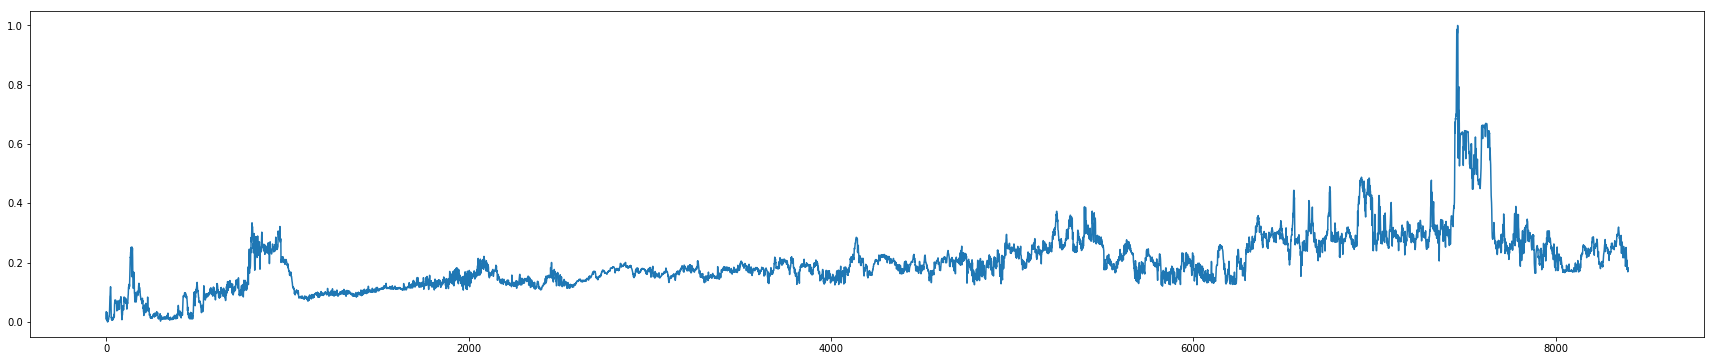

In [49]:
serie_sqrt = sc.fit_transform(serie["price"].apply(np.sqrt).values.reshape(-1,1)).reshape(-1,)
figure(figsize=(30,6))
plt.plot(serie_sqrt)

#### Tuninig Retardos

In [50]:
## evaluo los resultados de la calibración de los retardos para la transformación de la raíz cuadrada 
resultado_retardos_sqrt = tuning_retardos(retardos,serie_sqrt)

In [51]:
## Obtengo el mejor parámetro
mejor_retardo_sqrt = evaluacion(resultado_retardos_sqrt,retardos)

In [52]:
## Un retardo de 5 registros 
mejor_retardo_sqrt

0    0.849737
1    0.000163
Name: 5, dtype: float64

#### Tuning LR

In [53]:
## evaluo los resultados de la calibración de la LR para la transformación de la raíz cuadrada 
resultado_lr_sqrt = tuning_lr(lr,serie_sqrt)

In [54]:
## Obtengo el mejor parámetro
mejor_lr_sqrt = evaluacion(resultado_lr_sqrt,lr)

In [55]:
## Una tasa de aprendizaje de 0.04
mejor_lr_sqrt

0    0.852226
1    0.000160
Name: 0.04, dtype: float64

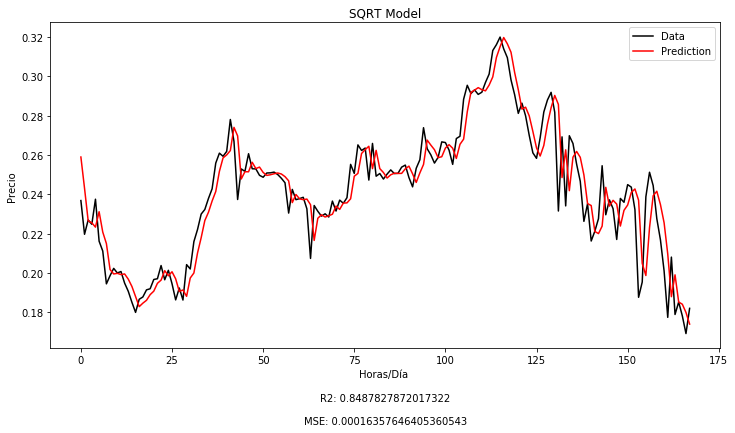

In [56]:
modelo_sqrt = adaline(5,0.04,serie_sqrt)

graficar_modelo(modelo_sqrt[0],modelo_sqrt[1],"SQRT Model")

### Raíz Cúbica

In [57]:
serie_cbrt = sc.fit_transform(np.array(serie["price"].apply(np.cbrt).values.reshape(-1,1))).reshape(-1,)

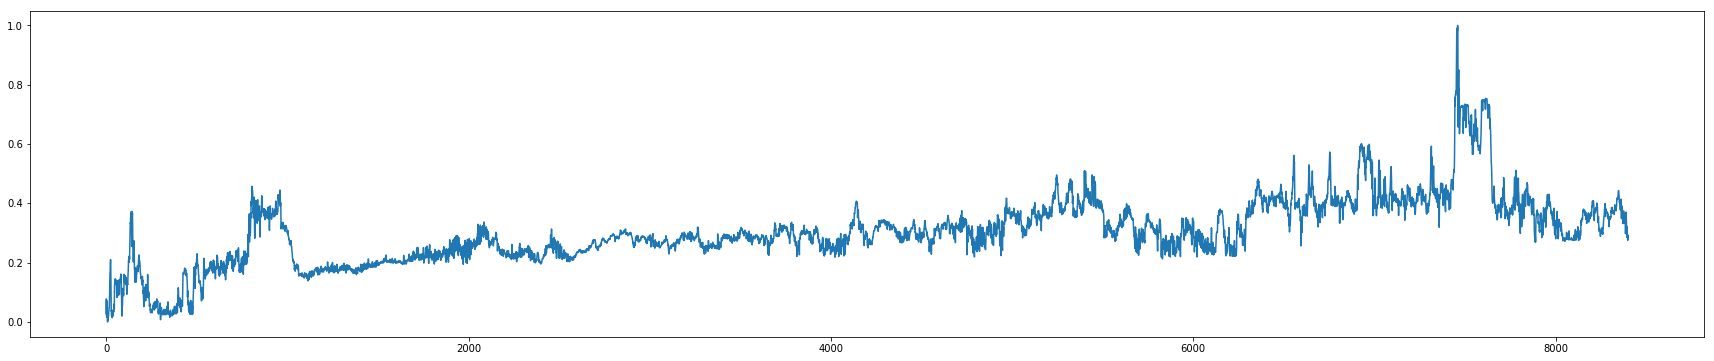

In [58]:
figure(figsize=(30,6))
plt.plot(serie_cbrt)

#### Tuninig Retardos

In [59]:
## evaluo los resultados de la calibración de los retardos para la transformación de la raíz cúbica
resultado_retardos_cbrt = tuning_retardos(retardos,serie_cbrt)

In [60]:
resultado_retardos_cbrt = resultado_retardos_cbrt[0:6]

In [61]:
## Obtengo el mejor parámetro
mejor_retardo_cbrt = evaluacion(resultado_retardos_cbrt,retardos[0:6])

In [62]:
## Un retardo de 5 registros 
mejor_retardo_sqrt

0    0.849737
1    0.000163
Name: 5, dtype: float64

#### Tuning LR

In [63]:
## evaluo los resultados de la calibración de la LR para la transformación de la raíz cúbica
resultado_lr_cbrt = tuning_lr(lr,serie_cbrt)

In [64]:
## Obtengo el mejor parámetro
mejor_lr_cbrt = evaluacion(resultado_lr_cbrt,lr)

In [65]:
## Una tasa de aprendizaje de 0.03
mejor_lr_cbrt

0    0.849796
1    0.000201
Name: 0.03, dtype: float64

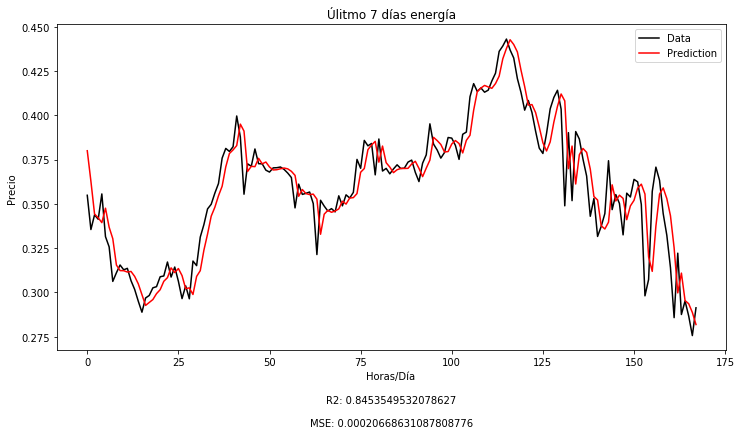

In [66]:
modelo_cbrt = adaline(5,0.03,serie_cbrt)

graficar_modelo(modelo_cbrt[0],modelo_cbrt[1],"Úlitmo 7 días energía")

### Logaritmo natural 

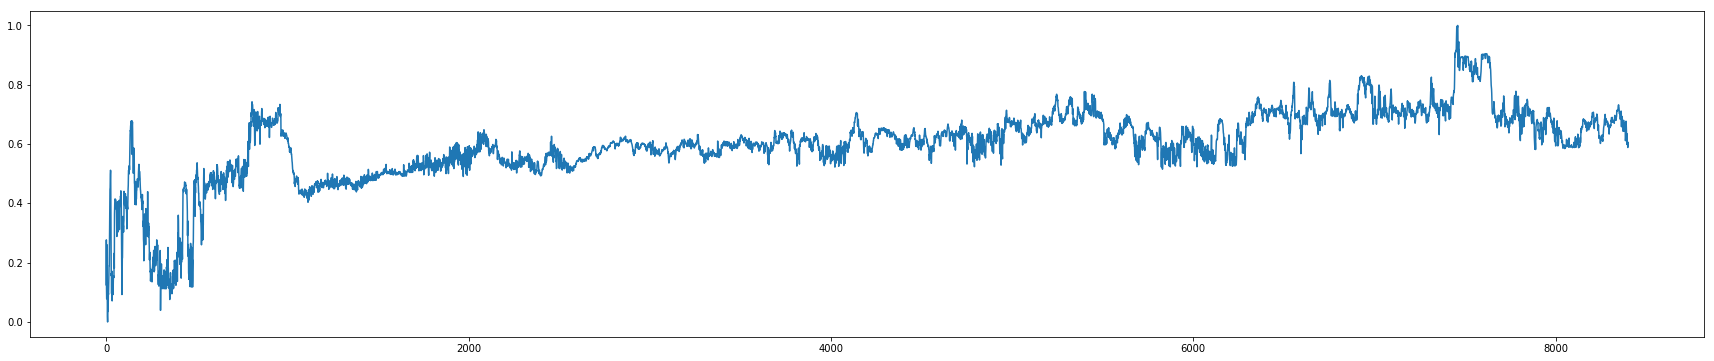

In [67]:
serie_log = sc.fit_transform(np.array(serie["price"].apply(np.log).values).reshape(-1,1)).reshape(-1,)
figure(figsize=(30,6))
plt.plot(serie_log)

#### Tuninig Retardos

In [68]:
## evaluo los resultados de la calibración de los retardos para la transformación de logaritmo natural
resultado_retardos_log = tuning_retardos(retardos,serie_log)

In [69]:
## Obtengo el mejor parámetro
mejor_retardo_log = evaluacion(resultado_retardos_log[:-3],retardos[:-3])

In [70]:
## Un retardo de 2 registros 
mejor_retardo_log

0    0.847960
1    0.000151
Name: 2, dtype: float64

#### Tuning LR

In [71]:
## evaluo los resultados de la calibración de la lr para la transformación del logaritmo natural
resultado_lr_log = tuning_lr(lr,serie_log)

In [72]:
## Obtengo el mejor parámetro
mejor_lr_log = evaluacion(resultado_lr_log[:-2],lr[:-2])

In [73]:
## Una tasa de aprendizaje de 0.04
mejor_lr_sqrt

0    0.852226
1    0.000160
Name: 0.04, dtype: float64

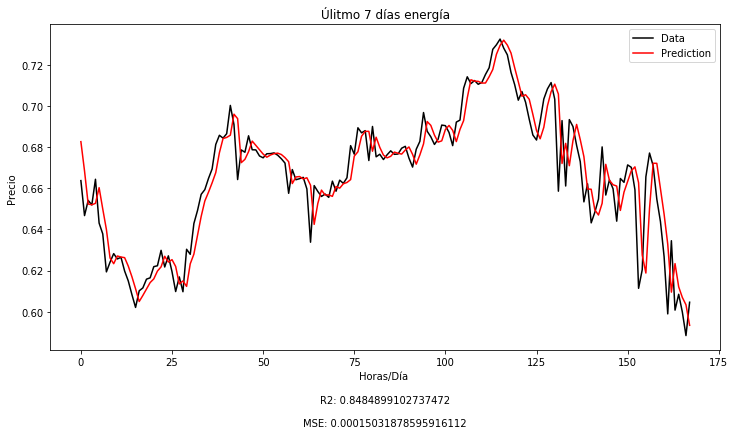

In [74]:
modelo_log = adaline(2,0.04,serie_log)

graficar_modelo(modelo_log[0],modelo_log[1],"Úlitmo 7 días energía")

**Resultados de los modelos con Adaline:**
    
    Sin transformación: 
        * MSE          0.0000387     * R2       0.8562

    Raíz Cuadrada
         * MSE         0.0001635      * R2       0.0001635

    Raíz Cúbica
         * MSE         0.0002066      * R2       0.845354

    Logaritmo Natural
         * MSE         0.0001503      * R2       0.8484899